In [1]:
import numpy as np
from pymergence.StochasticMatrix import StochasticMatrix
from pymergence.CoarseGraining import CoarseGraining
import matplotlib.pyplot as plt
from pymergence.core import *
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size']   = 16

# First define two visualization functions:

In [2]:

def visualize_network_scales(network,
                             partitions,
                             k=100,
                             scale=1.2,
                             node_size=5000,
                             figsize=(8,8),
                             font_size=30):

    """Plotting function: Visualizes a network with multiple partitions using NetworkX and Matplotlib."""
    # 1) Build DiGraph
    n = network.n_states
    G = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            w = network.matrix[i, j]
            if w > 0:
                G.add_edge(i, j, weight=w)

    # 2) Make subplots: one subplot per partition
    num_partitions = len(partitions)
    fig, axes = plt.subplots(1, num_partitions, figsize=(figsize[0]*num_partitions, figsize[1]))
    if num_partitions == 1:
        axes = [axes]  # ensure it's a list

    # 3) Layout, same as pastel
    pos = nx.spring_layout(G, k=k, scale=scale, seed=42)

    # 4) Build a standard 'grayscale' function from pastel
    def pick_gray(prob):
        p = max(min(prob, 1.0), 0.0)
        val = 0.6*(1.0 - p)  # p=1 => black(0), p=0 => 0.6 => lighter gray
        return str(val)

    # 5) Initialize a dictionary of node->color (start each node with a base color)

    node_color_palette = [
        "#FFB6C1","#FFDAC1","#FFFACD","#EEFFFF","#B0E0E6",
        "#C1FFC1","#FFDAB9","#DDA0DD","#F5DEB3","#E6E6FA"
    ]
    node_to_color = {}
    for i_node in range(n):
        node_to_color[i_node] = node_color_palette[i_node % len(node_color_palette)]

    # 6) Precompute edges & their colors
    all_edges = list(G.edges(data=True))
    normal_edges = [(u,v) for (u,v,_) in all_edges if u!=v]
    self_loops  = [(u,v) for (u,v,_) in all_edges if u==v]

    edge_color_map = {}
    for (u,v,data) in all_edges:
        prob = data["weight"]
        edge_color_map[(u,v)] = pick_gray(prob)

    ###################################################
    # Helper to unify colors across blocks in a partition
    ###################################################
    def merge_colors_for_partition(this_partition):
        """
        E.g. if this_partition = [[0,1],[2],[3,4]]
        then nodes 0&1 share the same color, nodes 3&4 share the same color, etc.
        """
        for block in this_partition:
            if len(block) < 2:
                # single node => no merge needed
                continue
            # gather how many nodes of each color exist in this block
            block_color_count = {}
            for nd in block:
                c = node_to_color[nd]
                block_color_count[c] = block_color_count.get(c,0)+1
            # find color with max count
            max_count = max(block_color_count.values())
            winners = [c for (c,cnt) in block_color_count.items() if cnt==max_count]
            chosen_color = winners[0]  # if tie, pick the first or random
            # unify all nodes in this block to chosen_color
            for nd in block:
                node_to_color[nd] = chosen_color

    #####################
    # 7) Now, for each partition i_part in partitions, unify colors
    #    Then draw the network in axes[i_part].
    #####################
    for i_part, part_blocks in enumerate(partitions):
        ax = axes[i_part]
        plt.sca(ax)

        # If i_part>0, unify node colors using that partition
        if i_part>0:
            merge_colors_for_partition(part_blocks)

        # Build the list of node colors
        current_node_colors = [node_to_color[i_nd] for i_nd in range(n)]

        # Draw NODES (same as pastel style)
        nx.draw_networkx_nodes(
            G, pos,
            node_size=node_size,
            node_color=current_node_colors,
            edgecolors='black',
            linewidths=2
        )

        # Draw normal edges with pastel arrow settings
        nx.draw_networkx_edges(
            G, pos,
            edgelist=normal_edges,
            edge_color=[edge_color_map[ed] for ed in normal_edges],
            arrows=True,
            arrowstyle='-|>',
            arrowsize=25,
            width=3,
            connectionstyle='arc3,rad=0.2',
            min_source_margin=15,
            min_target_margin=15,
            node_size=node_size
        )

        # Draw self-loops with bigger arc
        nx.draw_networkx_edges(
            G, pos,
            edgelist=self_loops,
            edge_color=[edge_color_map[ed] for ed in self_loops],
            arrows=True,
            arrowstyle='-|>',
            arrowsize=25,
            width=3,
            connectionstyle='arc3,rad=0.5',
            node_size=node_size
        )

        # Draw labels
        nx.draw_networkx_labels(
            G, pos,
            labels={i_nd:str(i_nd) for i_nd in range(n)},
            font_size=font_size,
            font_color='black'
        )

        ax.set_title(f"Partition {i_part+1}", fontsize=font_size)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_network_pastel_with_chosen_partition(
    network,
    chosen_partition,
    k=0.5,
    scale=1.2,
    node_size=5000,
    figsize=(8,8),
    font_size=25
):

    #################################
    # 1) Force Arial font
    #################################
    mpl.rcParams['font.family'] = 'Arial'

    #################################
    # 2) Build a coarse-grained DiGraph from chosen_partition
    #################################
    n_blocks = len(chosen_partition)
    CG = nx.DiGraph()

    # Ensure each block node exists in CG, even if it has no edges
    CG.add_nodes_from(range(n_blocks))

    # Summation of adjacency from the original micro-level network
    for i_block in range(n_blocks):
        for j_block in range(n_blocks):
            weight_sum = 0.0
            for src in chosen_partition[i_block]:
                for tgt in chosen_partition[j_block]:
                    weight_sum += network[src, tgt]
            if weight_sum > 0:
                CG.add_edge(i_block, j_block, weight=weight_sum)

    #################################
    # 3) Layout
    #################################
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(CG, k=k, scale=scale, seed=42)

    #################################
    # 4) Pastel node colors
    #################################
    node_color_palette = [
        "#FFB6C1","#FFDAC1","#FFFACD","#EEFFFF","#B0E0E6",
        "#C1FFC1","#FFDAB9","#DDA0DD","#F5DEB3","#E6E6FA"
    ]
    block_colors = []
    for i_b in range(n_blocks):
        color_idx = i_b % len(node_color_palette)
        block_colors.append(node_color_palette[color_idx])

    #################################
    # 5) Grayscale function for edges
    #################################
    def pick_gray(prob):
        p = max(min(prob,1.0), 0.0)
        val = 0.6 * (1.0 - p)  # p=1 => black(0), p=0 => 0.6 => mid-gray
        return str(val)

    # Distinguish normal edges vs self-loops
    all_edges = list(CG.edges(data=True))
    normal_edges = []
    self_loops   = []
    edge_color_map = {}
    for (u,v,data) in all_edges:
        w = data["weight"]
        color = pick_gray(w)
        edge_color_map[(u,v)] = color
        if u==v:
            self_loops.append((u,v))
        else:
            normal_edges.append((u,v))

    normal_colors   = [edge_color_map[(u,v)] for (u,v) in normal_edges]
    selfloop_colors = [edge_color_map[(u,v)] for (u,v) in self_loops]

    #################################
    # 6) Node sizes & labels
    #################################
    block_sizes  = []
    block_labels = {}
    for i_b, block in enumerate(chosen_partition):
        # e.g. bigger if multiple micro-states
        size_factor = 1.0 + 0.3*(len(block)-1)
        block_sizes.append(node_size * size_factor)
        if len(block)==1:
            block_labels[i_b] = str(block[0])
        else:
            block_labels[i_b] = ",".join(str(x) for x in block)

    #################################
    # 7) Draw the nodes
    #################################
    nx.draw_networkx_nodes(
        CG, pos,
        nodelist=range(n_blocks),
        node_size=block_sizes,
        node_color=block_colors,
        edgecolors='black',
        linewidths=2
    )

    # labels
    nx.draw_networkx_labels(
        CG, pos,
        labels=block_labels,
        font_size=font_size,
        font_color='black'
    )

    #################################
    # 8) Draw normal edges
    #################################
    nx.draw_networkx_edges(
        CG, pos,
        edgelist=normal_edges,
        edge_color=normal_colors,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=25,
        width=3,
        connectionstyle='arc3,rad=0.2',
        min_source_margin=15,
        min_target_margin=15,
        node_size=block_sizes
    )

    #################################
    # 9) Draw self-loops with BIG arcs
    #################################
    nx.draw_networkx_edges(
        CG, pos,
        edgelist=self_loops,
        edge_color=selfloop_colors,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=25,
        width=3,
        # Here's the big arc
        connectionstyle='arc3,rad=2.0',
        # Large margins so arrow doesn't vanish behind big nodes
        min_source_margin=100,
        min_target_margin=100,
        node_size=block_sizes
    )

    #################################
    # 10) Done
    #################################
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# We then construct a network with a clear macroscale, which can be recognized by all CP values

/Users/abel/Documents/Bicameral/pymergence/pymergence/StochasticMatrix.py:332: RuntimeWarning: divide by zero encountered in divide
  weights = np.ones(self.n_states) / (self.n_states-1)


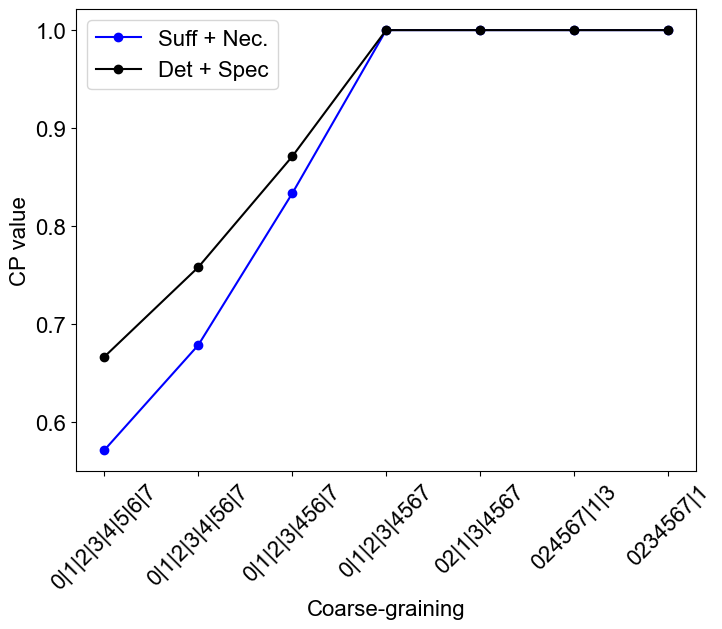

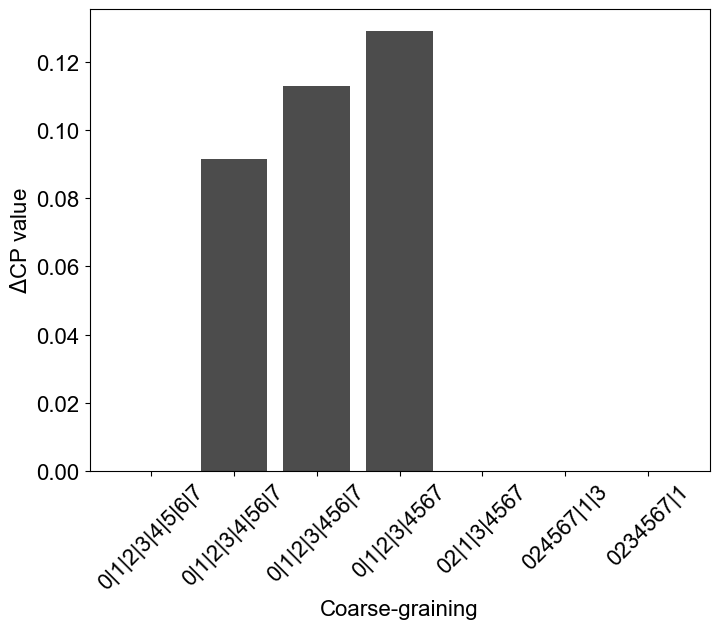

In [ ]:
network = np.array([
    [1.0,    0,  0,  0,    0,    0,  0,  0],  # State 0: Equal chance to go to states 1, 2, 5, 6, or 7
    [0,  1.0,    0,    0,    0,    0,    0,    0],    # State 1: Always transitions to state 0
    [0,  0,    1.0,    0,  0,    0,    0,    0],    # State 2: 50% chance to go to states 3 or 0
    [0,    0,    0,  1.0,    0,  0,    0,    0],    # State 3: 50% chance to go to states 4 or 2
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 4: Always transitions to state 3
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 5: Always transitions to state 0
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 6: Always transitions to state 0
    [0,    0,    0,    0,  1/4,    1/4,    1/4,    1/4],    # State 7: Always transitions to state 0
])
# Create a stochastic matrix from the network
stochMat = StochasticMatrix(network)
all_coarse_grainings = generate_all_coarse_grainings(8)
consistent_coarse_grainings = stochMat.find_consistent_coarse_grainings(all_coarse_grainings)
hasse_diagram_cons = refinement_graph(consistent_coarse_grainings)

# Calculate both kinds of CP values for the consistent coarse-grainings
cp_values_cons_eff, _ = calc_CP_along_CGs(stochMat, consistent_coarse_grainings, mode='effectiveness')
cp_values_cons_suff_plus_nec, _ = calc_CP_along_CGs(stochMat, consistent_coarse_grainings, mode='suff_plus_nec')

# Find the single path as defined in the CE2.0 paper
single_patheff = find_single_path(hasse_diagram_cons, cp_values_cons_eff)
single_pathsuff_plus_nec = find_single_path(hasse_diagram_cons, cp_values_cons_suff_plus_nec)

# Plot the results
partition_labels = [partition_stats[0] for partition_stats in single_patheff]
effectiveness_values = [partition_stats[1] for partition_stats in single_patheff]
delta_effectiveness_values = [partition_stats[2] for partition_stats in single_patheff]
suff_plus_nec_values = [partition_stats[1] for partition_stats in single_pathsuff_plus_nec]

plt.figure(figsize=(8,6))
plt.plot(suff_plus_nec_values, marker='o', label='Suff + Nec.', color='blue')
plt.plot(effectiveness_values, marker='o', label='Det + Spec', color='black')
plt.xticks(range(len(single_patheff)), partition_labels, rotation=45)
plt.xlabel('Coarse-graining')
plt.ylabel('CP value')
plt.legend()
plt.show()

CE = sum([partition_stats[2] for partition_stats in single_patheff])

plt.figure(figsize=(8,6))
plt.bar(x = np.arange(len(single_patheff)), height = delta_effectiveness_values, color='black', alpha=0.7)
plt.xticks(np.arange(len(single_patheff)), partition_labels, rotation=45)
plt.xlabel('Coarse-graining')
plt.ylabel(r'$\Delta$CP value')
plt.show()


# The method to find a single micro-macro path finds the 'correct' coarse-grainings:

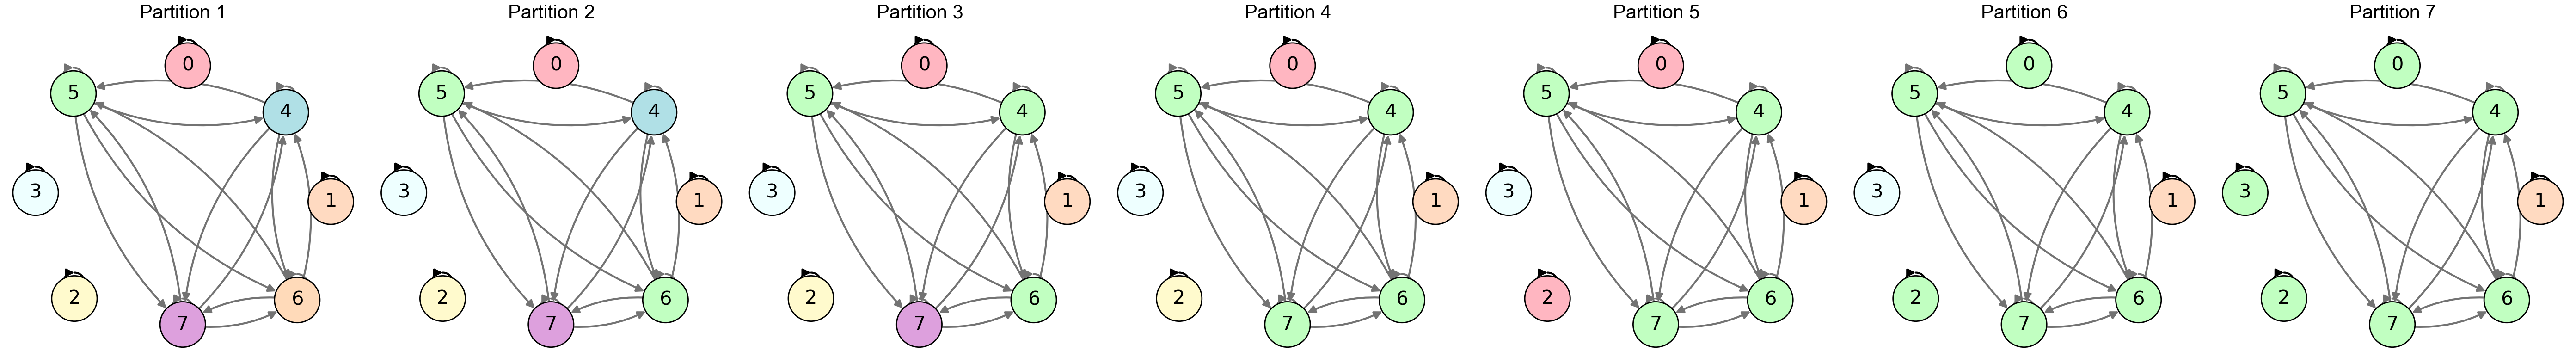

In [ ]:
partitions = []
for partition in single_patheff:
    partitions.append(tuple(tuple(int(i) for i in block) for block in partition[0].split('|')))

visualize_network_scales(stochMat, partitions, k=100, scale=1.2, node_size=5000, figsize=(8,8), font_size=30)


# Once the macro-level is reached, there are only self-loops left:

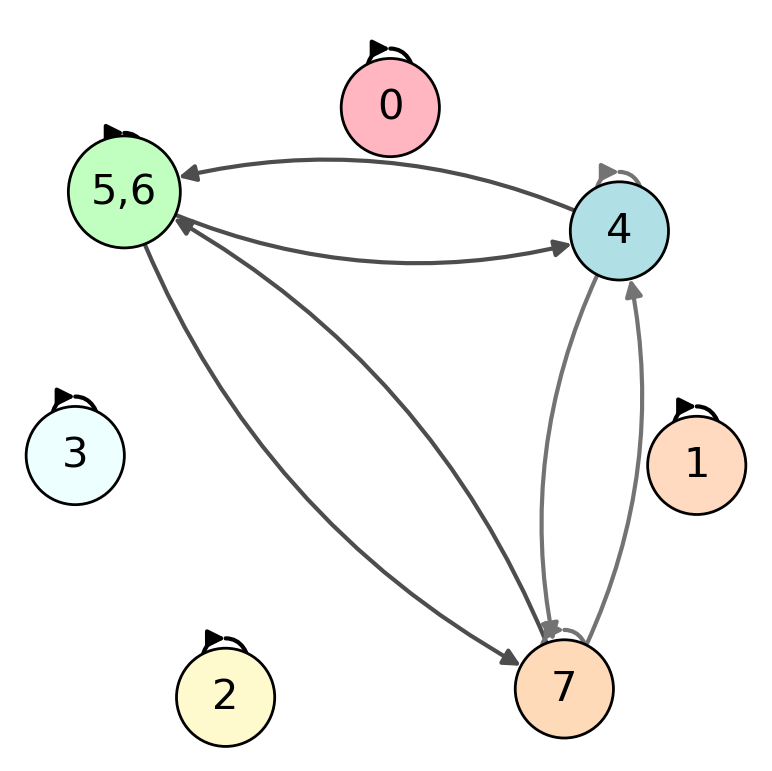

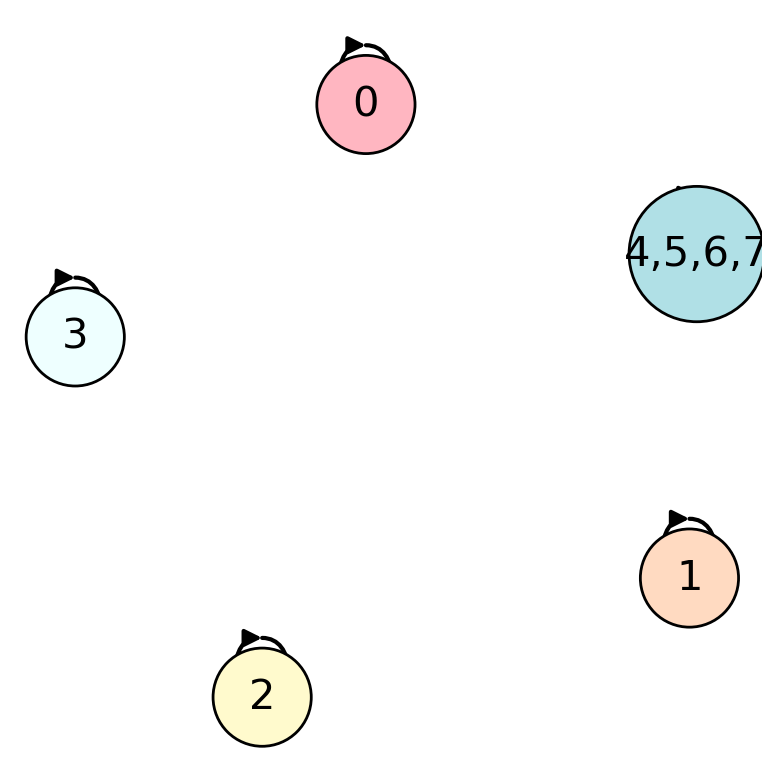

In [5]:
visualize_network_pastel_with_chosen_partition(stochMat.matrix, partitions[1], k=100, scale=1.2, node_size=5000, figsize=(8,8), font_size=30)

visualize_network_pastel_with_chosen_partition(stochMat.matrix, partitions[3], k=100, scale=1.2, node_size=5000, figsize=(8,8), font_size=30)


# Now on to a more interesting example

/Users/abel/Documents/Bicameral/pymergence/pymergence/StochasticMatrix.py:332: RuntimeWarning: divide by zero encountered in divide
  weights = np.ones(self.n_states) / (self.n_states-1)


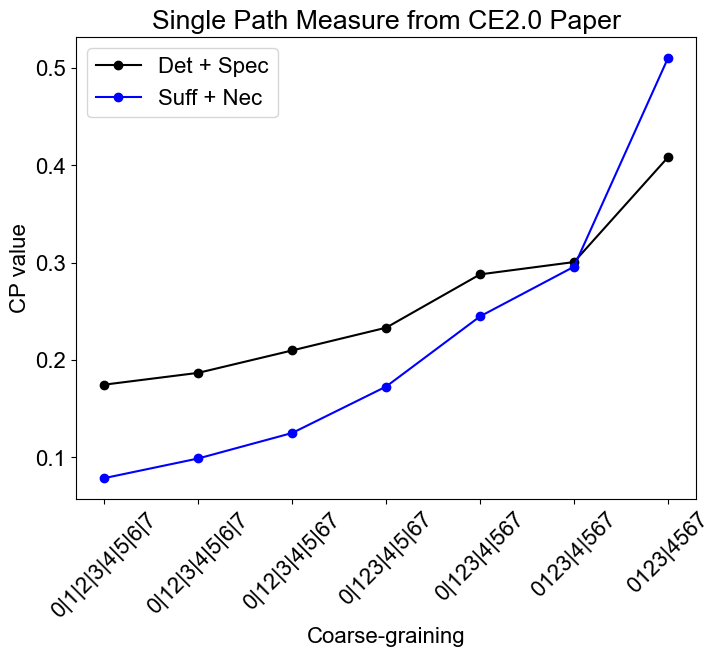

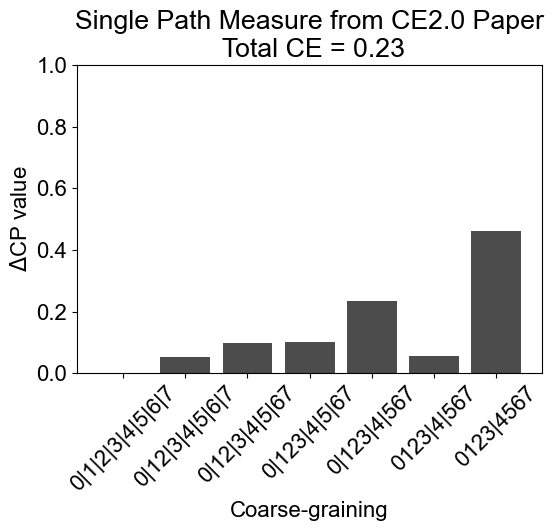

In [ ]:
network = np.array([
    [2/14, 0, 0, 0, 3/14, 3/14, 3/14, 3/14],
    [0, 1/21, 1/21, 1/21, 3/14, 3/14, 3/14, 3/14],
    [0, 1/21, 1/21, 1/21, 3/14, 3/14, 3/14, 3/14],
    [0, 1/21, 1/21, 1/21, 3/14, 3/14, 3/14, 3/14],
    [3/14, 3/14, 3/14, 3/14, 2/14, 0, 0, 0],
    [3/14, 3/14, 3/14, 3/14, 0, 1/21, 1/21, 1/21],
    [3/14, 3/14, 3/14, 3/14, 0, 1/21, 1/21, 1/21],
    [3/14, 3/14, 3/14, 3/14, 0, 1/21, 1/21, 1/21]
])

# Create a stochastic matrix from the network
stochMat = StochasticMatrix(network)
all_coarse_grainings = generate_all_coarse_grainings(8)
consistent_coarse_grainings = stochMat.find_consistent_coarse_grainings(all_coarse_grainings)
hasse_diagram_cons = refinement_graph(consistent_coarse_grainings)

# Calculate both kinds of CP values for the consistent coarse-grainings
cp_values_cons_eff, _ = calc_CP_along_CGs(stochMat, consistent_coarse_grainings, mode='effectiveness')
cp_values_cons_suff_plus_nec, _ = calc_CP_along_CGs(stochMat, consistent_coarse_grainings, mode='suff_plus_nec')

# Find the single path as defined in the CE2.0 paper
single_patheff = find_single_path(hasse_diagram_cons, cp_values_cons_eff)
single_pathsuff_plus_nec = find_single_path(hasse_diagram_cons, cp_values_cons_suff_plus_nec, demand_nonzero_delta=False)

# Plot the results
partition_labels = np.array([partition_stats[0] for partition_stats in single_patheff])
effectiveness_values = np.array([partition_stats[1] for partition_stats in single_patheff])
delta_effectiveness_values = np.array([partition_stats[2] for partition_stats in single_patheff])
suff_plus_nec_values = np.array([partition_stats[1] for partition_stats in single_pathsuff_plus_nec])

plt.figure(figsize=(8,6))
plt.plot(effectiveness_values, marker='o', label='Det + Spec', color='black')
plt.plot(suff_plus_nec_values, marker='o', label='Suff + Nec', color='blue')
plt.xticks(range(len(single_patheff)), partition_labels, rotation=45)
plt.xlabel('Coarse-graining')
plt.ylabel('CP value')
plt.title('Single Path Measure from CE2.0 Paper')
plt.legend()
plt.show()

CE = sum([partition_stats[2] for partition_stats in single_patheff])

delta_effectiveness_values_norm = delta_effectiveness_values / np.sum(delta_effectiveness_values)

plt.figure(figsize=(6, 4))
plt.bar(x = np.arange(len(single_patheff)), height = delta_effectiveness_values_norm, color='black', alpha=0.7)
plt.xticks(np.arange(len(single_patheff)), partition_labels, rotation=45)
plt.ylim([0, 1])
plt.xlabel('Coarse-graining')
plt.ylabel(r'$\Delta$CP value')
plt.title('Single Path Measure from CE2.0 Paper\n Total CE = {:.2f}'.format(CE))
plt.show()



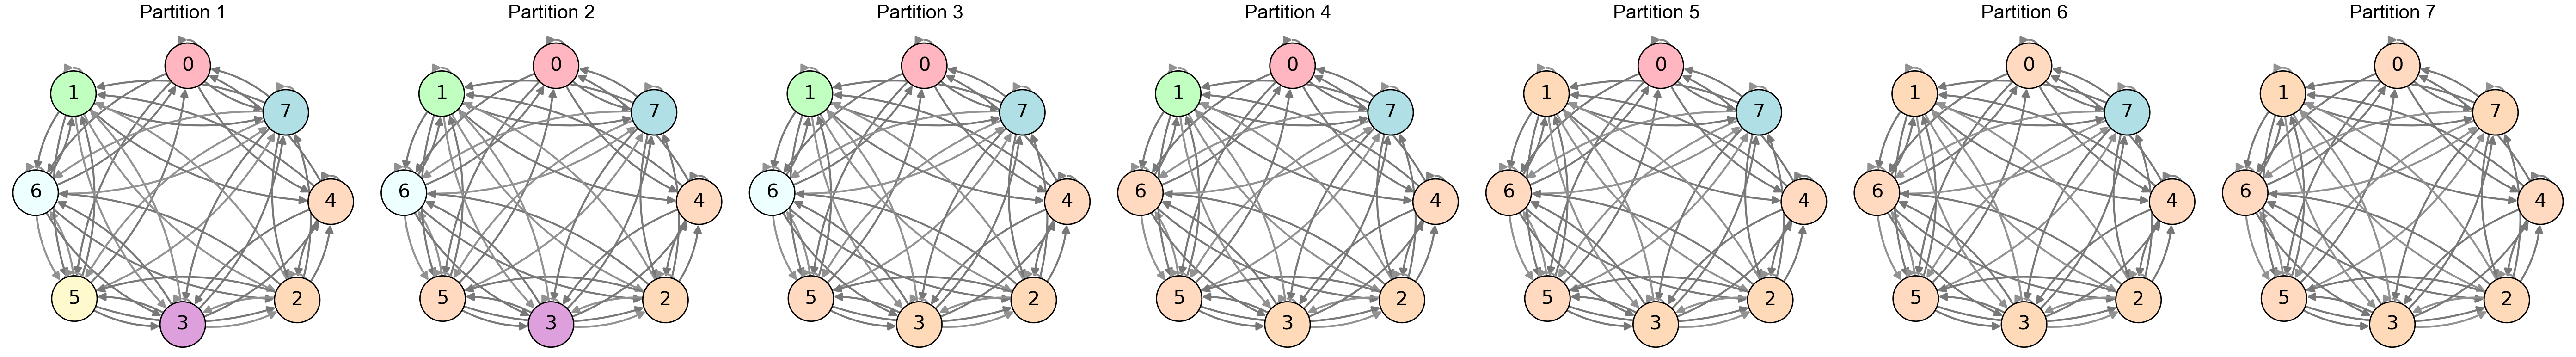

In [ ]:
partitions = []
for partition in single_patheff:
    partitions.append(tuple(tuple(int(i) for i in block) for block in partition[0].split('|')))
visualize_network_scales(stochMat, partitions, k=100, scale=1.2, node_size=5000, figsize=(8,8), font_size=30)


# We see causal emergence decay with increasing noise

In [8]:
def block_uniform_to_diagonal(n_steps=10, N=8):
    """
    Creates a list of (n_steps+1) TPMs, each N x N, transitioning from:
      p=0 (fully uniform blocks) to p=1 (fully diagonal in each block).
    """
    if N % 2 != 0:
        raise ValueError("N must be even for this block design.")
    
    half = N // 2
    tpm_list = []
    for step in range(n_steps + 1):
        p = step / float(n_steps)  # goes 0..1
        T = np.zeros((N, N), dtype=float)

        # Top block rows
        for i in range(half):
            for j in range(half):
                T[i, j] = (1 - p) / 4
            T[i, i] += p

        # Bottom block rows
        for i in range(half, N):
            for j in range(half, N):
                T[i, j] = (1 - p) / 4
            T[i, i] += p

        tpm_list.append(T)
    return tpm_list

In [9]:
steps = 50
N = 8
# Generate the block uniform to diagonal TPMs
block_uniform_to_diagonal_matrices = block_uniform_to_diagonal(n_steps=steps, N=N)
all_coarse_grainings = generate_all_coarse_grainings(N)

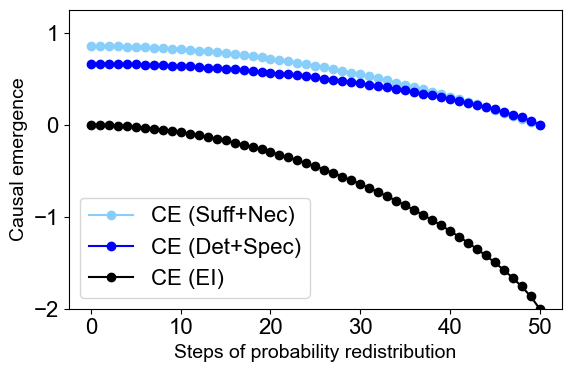

In [10]:
suff_plus_nec_CE_values = []
effectiveness_CE_values = []
effective_information_CE_values = []

for tpm in block_uniform_to_diagonal_matrices:
    stochMat = StochasticMatrix(tpm)
    effectiveness_CE_values.append(1 - stochMat.effectiveness())
    suff_plus_nec_CE_values.append(2 - stochMat.suff_plus_nec())
    effective_information_CE_values.append(1 - stochMat.effective_information())

plt.figure(figsize=(6, 4))
y_min = -2
y_max = 1.25
plt.ylim(y_min, y_max)
plt.plot(suff_plus_nec_CE_values, marker='o', color='lightskyblue', label='CE (Suff+Nec)')
plt.plot(effectiveness_CE_values, marker='o', color='blue',         label='CE (Det+Spec)')
plt.plot(effective_information_CE_values, marker='o', color='black',label='CE (EI)')

plt.xlabel("Steps of probability redistribution", fontsize=14)
plt.ylabel("Causal emergence", fontsize=14)
plt.ylim(-2, 1.25)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [11]:
def simple_noise_matrix_with_mixing(n, s):
    """
    Build an n x n transition matrix at step s in [0..n], 
    same as before:
      1) Do the usual 'simple noise' row pattern:
         M[i,i]   = (n-s)/n
         M[i,(i+1..i+s) mod n] = 1/n
      2) For k in [1..s], row k is 'merged' with row 0,
         i.e. row k = row 0 exactly.
    """
    if s == n:
        return np.ones((n,n), dtype=float) / n
    
    M = np.zeros((n,n), dtype=float)
    for i in range(n):
        # main diagonal
        M[i,i] = (n-s)/n
        # next s columns => 1/n
        for k in range(1, s+1):
            j = (i + k) % n
            M[i,j] = 1.0/n
    
    # merging logic: for each k in [1..s], copy row 0
    for k in range(1, s+1):
        if k < n:
            M[k,:] = M[0,:]
    
    return M


def simple_mixing_sequence_with_calcs(n):
    """
    Generate a sequence of mixing matrices from step 0 to n
    """
    results = []
    for s in range(n+1):
        M_s = simple_noise_matrix_with_mixing(n, s)
        M_s = StochasticMatrix(M_s)  # Convert to StochasticMatrix for calculations

        suffNec = M_s.suff_plus_nec()
        suffNec_normalized = suffNec - 1

        ded_combined_normalized = M_s.effectiveness()

        results.append( (M_s, suffNec_normalized, ded_combined_normalized) )

    return results

In [12]:
n=30
noisy_matrices = simple_mixing_sequence_with_calcs(n)

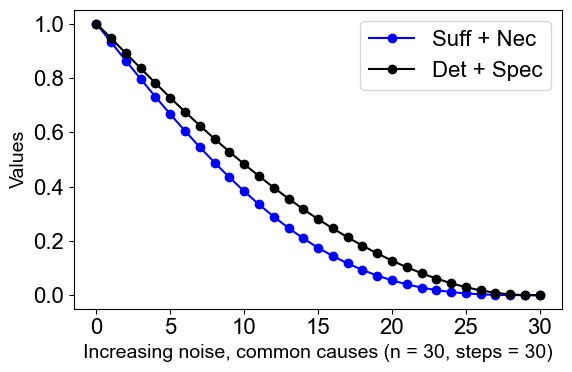

In [13]:
suff_plus_nec_CE_values = []
effectiveness_CE_values = []

for m in noisy_matrices:
    suff_plus_nec_CE_values.append(m[1])
    effectiveness_CE_values.append(m[2])
plt.figure(figsize=(6, 4))
plt.plot(suff_plus_nec_CE_values, marker='o', label=r'Suff + Nec', color='blue')
plt.plot(effectiveness_CE_values, marker='o', label=r'Det + Spec', color='black')
plt.xlabel(f"Increasing noise, common causes (n = {n}, steps = {n})", fontsize=14)
plt.ylabel("Values", fontsize=14)
# plt.ylim(-2, 1.25)
plt.legend(loc='best')
plt.tight_layout()
plt.show()